#### 1. What is a GradCAM?

- GradCAM (Gradient-weighted Class Activation Mapping) is a technique used in deep learning and computer vision to visualize the regions of an input image that contribute the most to the predictions made by a neural network model. 
- It highlights the important regions by generating a heatmap that shows where the model's attention is focused within the image. 
- GradCAM achieves this by using gradients of the model's output with respect to the input image to determine the importance of each pixel.

*Imagine you have a super cool pair of glasses that can show you exactly what your brain is thinking about. Well, in a way, GradCAM is like those glasses, but for computers and pictures.*

*You know how when you look at a picture, you can tell what's important in it, like a bright smile on someone's face or a cute puppy in the background? GradCAM helps computers do something similar. It helps them figure out what parts of a picture they are paying the most attention to when they're trying to understand it.*.

*Let's say we have a picture of a sunny beach with lots of things happening: people playing in the sand, waves crashing, and colorful umbrellas. When a computer wants to understand what's happening in the picture, it uses something called a `Neural Network` (that's like the computer's brain) to look at all the different parts of the picture*.

*GradCAM helps the computer show us where it's focusing the most. It's like shining a bright light on the most interesting parts of the picture. So, if the computer is trying to figure out if there's a dog on the beach, GradCAM would show us which parts of the picture the computer thinks might have the dog – maybe near a group of people or by the water*.

In short, GradCAM helps us see what parts of a picture a computer thinks are the most important when it's trying to understand what's in the picture. Just like your brain focuses on the best parts of a story, GradCAM helps computers focus on the best parts of a picture to understand it better!



#### 2. Steps followed in Grad CAM. Let's understand each step involved in the `GradCAM` with respect to the "Sunny Beach" example

- Capture the output of the *last "detective" layer of the computer's brain that looks at the sunny beach picture*.

- Calculate how much each *"detective" (neuron) in the last layer cares about finding dogs on the beach*, using gradients.

- Find the average importance of each *"detective" across different parts of the picture to get a list of their interests in finding dogs*.

- Multiply the *different parts of the sunny beach picture with their corresponding "detective" interests to show which spots are important for detecting dogs*.

- Combine these *"important spots" to create a map that highlights areas where the computer thinks dogs are likely to be in the picture*.

#### 3. Load Dataset

- In this Notebook, lets explore the Fashion MNIST datset for understanding the GradCAM

- The shape of each image present in the dataset is `28x28`.
- The number of classes present in this train data - 60K images and test data - 10K images
- The data is converted into PyTorch Tensors.
- The data loaders are constructed to pass into the Neural Network


In [2]:
import torch

In [3]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

(X_train, Y_train), (X_test, Y_test) = keras.datasets.fashion_mnist.load_data()

X_train, X_test, Y_train, Y_test = torch.tensor(X_train, dtype=torch.float32),\
                                   torch.tensor(X_test, dtype=torch.float32),\
                                   torch.tensor(Y_train, dtype=torch.long),\
                                   torch.tensor(Y_test, dtype=torch.long)

X_train, X_test = X_train.reshape(-1,1,28,28), X_test.reshape(-1,1,28,28)

X_train, X_test = X_train/255.0, X_test/255.0

classes =  Y_train.unique()
class_labels = ["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]
mapping = dict(zip(classes.numpy(), class_labels))

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

4422102/4422102 [==============================] - 4s 1us/step


(torch.Size([60000, 1, 28, 28]),
 torch.Size([10000, 1, 28, 28]),
 torch.Size([60000]),
 torch.Size([10000]))

In [4]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train, Y_train)
test_dataset  = TensorDataset(X_test , Y_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

#### 4. Construct a Simple Convolutional Neural Network

- The Neural Network has 3 Convolutional Layers and 1 Linear Layer

- Convolutional Layer 1 with `48` Output channels
- Convolutional Layer 2 with `32` Output channels
- Convolutional Layer 3 with `16` Output channels
- The Last Linear layer has `10` Output units which is same as the number of classes

In [6]:
from torch import nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=48, kernel_size=(3,3), padding="same"),
            nn.ReLU(),

            nn.Conv2d(in_channels=48, out_channels=32, kernel_size=(3,3), padding="same"),
            nn.ReLU(),

            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(3,3), padding="same"),
            nn.ReLU(),

            nn.Flatten(),
            nn.Linear(16*28*28, len(classes))  
        )

    def forward(self, x_batch):
        preds = self.seq(x_batch)
        return preds

conv_net = ConvNet()
conv_net

ConvNet(
  (seq): Sequential(
    (0): Conv2d(1, 48, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(48, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=12544, out_features=10, bias=True)
  )
)

#### 5. Train Network

In [8]:
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import gc

def CalcValLoss(model, loss_func, val_loader):
    with torch.no_grad(): ## Prevents calculation of gradients
        val_losses = []
        for X_batch, Y_batch in val_loader:
            preds = model(X_batch)
            loss = loss_func(preds, Y_batch)
            val_losses.append(loss)
        print("Valid CategoricalCrossEntropy : {:.3f}".format(torch.tensor(val_losses).mean()))

def MakePredictions(model, loader):
    preds, Y_shuffled = [], []
    for X_batch, Y_batch in loader:
        preds.append(model(X_batch))
        Y_shuffled.append(Y_batch)

    preds = torch.cat(preds).argmax(axis=-1)
    Y_shuffled = torch.cat(Y_shuffled)
    return Y_shuffled, preds

def TrainModelInBatchesV1(model, loss_func, optimizer, train_loader, val_loader, epochs=5):
    for i in range(epochs):
        losses = [] ## Record loss of each batch
        for X_batch, Y_batch in tqdm(train_loader):
            preds = model(X_batch) ## Make Predictions by forward pass through network

            loss = loss_func(preds, Y_batch) ## Calculate Loss
            losses.append(loss) ## Record Loss

            optimizer.zero_grad() ## Zero weights before calculating gradients
            loss.backward() ## Calculate Gradients
            optimizer.step() ## Update Weights

        print("Train CategoricalCrossEntropy : {:.3f}".format(torch.tensor(losses).mean()))
        CalcValLoss(model, loss_func, val_loader)

        Y_test_shuffled, test_preds = MakePredictions(model, val_loader)
        val_acc = accuracy_score(Y_test_shuffled, test_preds)
        print("Val  Accuracy : {:.3f}".format(val_acc))
        gc.collect()

In [10]:
from torch.optim import SGD, RMSprop, Adam

epochs = 3
learning_rate = torch.tensor(1e-3) # 0.001

conv_net = ConvNet()
cross_entropy_loss = nn.CrossEntropyLoss()
optimizer = Adam(params=conv_net.parameters(), lr=learning_rate)

TrainModelInBatchesV1(conv_net, cross_entropy_loss, optimizer, train_loader, test_loader,epochs)

100%|██████████| 469/469 [01:46<00:00,  4.39it/s]


Train CategoricalCrossEntropy : 0.438
Valid CategoricalCrossEntropy : 0.339
Val  Accuracy : 0.873


100%|██████████| 469/469 [01:46<00:00,  4.42it/s]


Train CategoricalCrossEntropy : 0.286
Valid CategoricalCrossEntropy : 0.308
Val  Accuracy : 0.888


100%|██████████| 469/469 [01:46<00:00,  4.42it/s]


Train CategoricalCrossEntropy : 0.236
Valid CategoricalCrossEntropy : 0.270
Val  Accuracy : 0.905


#### 6. Grad CAM Step-by-Step Process Involved

#### 6.1 Capture Output Of Last Convolution Layer

- In the first step, lets capture the Output of the `Last Convolution Layer`. This is achieved by designing a secondary Convolutional Neural Network using the layers from our original neural network - `ConvNet`

- To retrieve the layers of our original network `ConvNet`, let's utilize the `children()` function applied to the network. This will allow us to access the various layers within the network

- Let's perform the forward pass on the secondary neural network, with a focus on capturing the `Last Convolution Layer`, a crucial component of our Task. This output is stored as a local member of this new network.

- A random sample is selected from our test data, and ran this selected sample through the new network using a `forward pass`

- The output of the step 6.1 is an output similar to what our original network would produce - 10 probabilities per sample. It is observed that the shape of the output from the last convolutional layer is `(1, 16, 28, 28)`. The `16` signifies the number of output channels from the convolutional layer, and the batch size of 1 reflects our focus on analyzing a single sample.

In [11]:
list(conv_net.children())[0]

Sequential(
  (0): Conv2d(1, 48, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): ReLU()
  (2): Conv2d(48, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (3): ReLU()
  (4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (5): ReLU()
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=12544, out_features=10, bias=True)
)

In [12]:
class LastConvLayerModel(nn.Module):
    def __init__(self):
        super(LastConvLayerModel, self).__init__()
        self.layers = list(list(conv_net.children())[0].children())

    def forward(self, X_batch):
        x = self.layers[0](X_batch)
        conv_layer_output = None
        for i, layer in enumerate(self.layers[1:]):
            x = layer(x)
            if i == 3:
                self.conv_layer_output = x
        return x

In [13]:
import numpy as np

conv_model = LastConvLayerModel()
idx = np.random.choice(range(10000))
pred = conv_model(X_test[idx:idx+1])

F.softmax(pred, dim=-1).argmax(), F.softmax(pred, dim=-1).max()

(tensor(3), tensor(0.9408, grad_fn=<MaxBackward1>))

In [14]:
conv_model.conv_layer_output.shape

torch.Size([1, 16, 28, 28])

In [15]:
print("Actual    Target : {}".format(mapping[Y_test[idx].item()]))
print("Predicted Target : {}".format(mapping[pred.argmax(dim=-1).item()]))

Actual    Target : T-shirt/top
Predicted Target : Dress


#### 6.2 Take Gradients Of Last Conv Layer Output With Respect to Prediction

- Now let's focus on calculating the gradient related to the last convolution layer's output concerning the predicted item. To achieve this, let's utilize the `grad()` function, which is available in the `autograd` sub-module of PyTorch

- Two arguments are passed into the `grad()` function.
    1.  First input is the `Predicted Probability`
    2.  Second input is the output originating from the `Last Convolution` layer.

    The `grad()` function takes these inputs and performs Gradient Calculations. Eventually returns the `computed gradients`

- The Shape of the `computed gradients` matches that of the last convolutional layer's output - `(1, 16, 28, 28)`

For our analysis, we calculated gradients with respect to the maximum predicted probability. However, it's possible to take gradients with respect to any of the 10 probabilities if our objective involves examining activations for other target classes.

In [16]:
from torch import autograd
grads = autograd.grad(pred[:, pred.argmax().item()], conv_model.conv_layer_output)
grads[0].shape

torch.Size([1, 16, 28, 28])

#### 6.3 Average Gradients

- First, we need to compute the gradients of the output tensor with respect to the `target` class. These gradients are usually obtained through backpropagation. Now we are interested in specific channel's gradients

- After obtaining the gradients, we will have a tensor that represents the gradients for each channel of the output. These gradients are computed for each location in the spatial dimensions (`height` and `width`) of the output `feature map`.

- The code `grads[0]` corresponds to selecting the gradients for a specific instance in the batch. In this case, it's the first instance. This step is usually done because when we perform backpropagation, we obtain gradients for each instance in the batch. But since we're interested in a specific instance, we choose `grads[0]`.

- The `mean` function calculates the average of the selected gradients along the specified dimensions `(0, 2, 3)`. Let's break down what this means
    1. `0` refers to the channel dimension. By taking the mean along this dimension, you're averaging the gradients across all the channels for the selected instance.
    
    2. `2` and `3` refer to the spatial dimensions (`height` and `width`). You're taking the mean across the spatial locations of each channel's gradients.

-  The resulting `pooled_grads` tensor will contain the average gradients for each channel. These average gradients give you an idea of how important each channel is for the predicted class.

In [17]:
pooled_grads = grads[0].mean((0,2,3))
pooled_grads

tensor([ 1.3793e-03,  1.7148e-03,  1.5112e-03,  0.0000e+00,  1.3891e-03,
         1.8316e-03,  1.7621e-04,  6.9941e-04,  1.6060e-03,  8.2878e-04,
         1.6342e-03,  1.3992e-03,  1.1351e-03,  1.5780e-03,  1.1473e-03,
        -2.7149e-05])

#### 6.4 Multiply Convolution Layer Output with Averaged Gradients

- Let's combine the Output of the Last Convolutional Layer with the averaged gradients obtained from the section 6.3

- Let's iterate through each channel of the output produced by the last convolutional layer. For every individual channel, we performed a multiplication with the corresponding averaged gradient value from the step 6.3.

- The outcome of this multiplication is an output array with a shape of `(16, 28, 28)`. This array provides us with a comprehensive view of how the convolutional layer's output interacts with the averaged gradients, highlighting critical regions where these interactions are most significant.

In [18]:
conv_output = conv_model.conv_layer_output.squeeze()
conv_output = F.relu(conv_output)
conv_output.shape

torch.Size([16, 28, 28])

In [19]:
for i in range(len(pooled_grads)):
    conv_output[i,:,:] *= pooled_grads[i]

conv_output.shape

torch.Size([16, 28, 28])

#### 6.5 Average Output At Channel Axis To Create Heatmap

- This final phase encapsulates our last step, which revolves around generating a heatmap. This heatmap is constructed by averaging the outputs at the channel level from the previous multiplication step.

- Specifically, we conducted an averaging operation across all 16 channels present in the output derived earlier. This endeavor yielded a heatmap characterized by a shape of (28, 28). The heatmap is strategically designed to encapsulate activations that play a role in influencing the network's predictions.

- As a customary practice to achieve enhanced outcomes, we often choose to normalize the values within the heatmap. This normalization process contributes to refining the resulting heatmap, thereby contributing to more accurate and interpretable insights into the neural network's decision-making process.

In [20]:
heatmap = conv_output.mean(dim=0).squeeze()
heatmap = heatmap / torch.max(heatmap)
heatmap.shape

torch.Size([28, 28])

#### 6.6 Visualize Original Image And Heatmap

- Let's visualize our original image and the heatmap next to each other to understand the performance of `GradCAM` algorithm.

- From the results, the heatmap highlights activations that contributed to the prediction.

/var/folders/tx/kp29vzg523qdz2m7wmtms4p40000gn/T/ipykernel_3461/1894943190.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap("Reds")


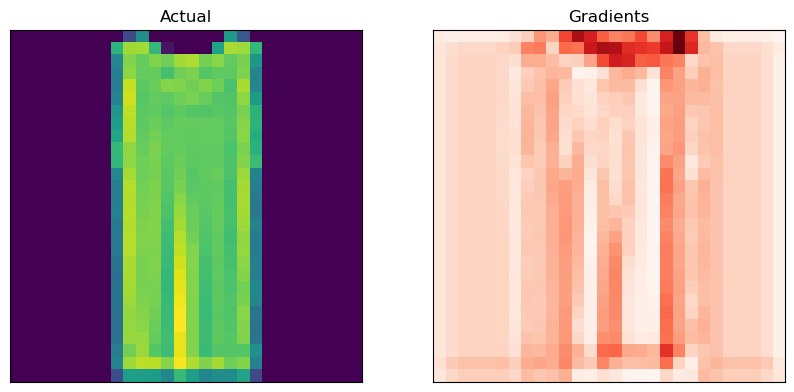

In [21]:
import matplotlib
import matplotlib.pyplot as plt

def plot_actual_and_heatmap(idx, heatmap):
    cmap = matplotlib.cm.get_cmap("Reds")

    fig = plt.figure(figsize=(10,10))
    ax1 = fig.add_subplot(121)
    ax1.imshow(X_test[idx].numpy().squeeze());
    ax1.set_title("Actual");
    ax1.set_xticks([],[]);ax1.set_yticks([],[]);

    ax2 = fig.add_subplot(122)
    ax2.imshow(heatmap, cmap="Reds");
    ax2.set_title("Gradients");
    ax2.set_xticks([],[]);ax2.set_yticks([],[]);

plot_actual_and_heatmap(idx, heatmap.detach())